   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   

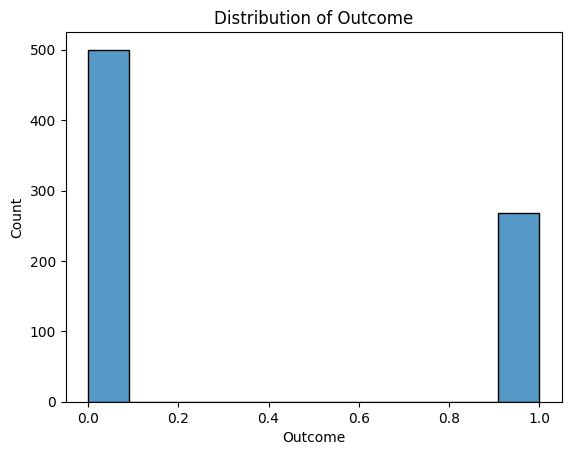

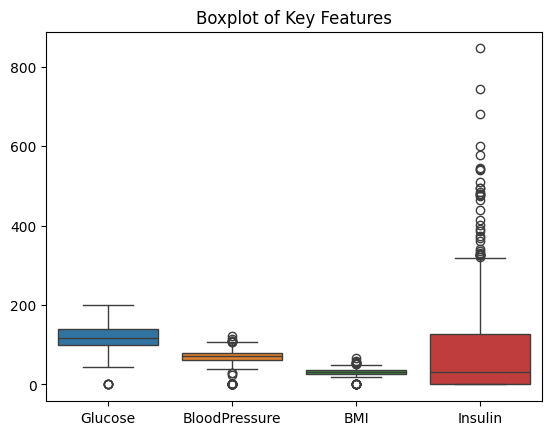

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.639947  0.865276      -0.021044       0.872057 -0.417768  0.167255   
1    -0.844885 -1.205989      -0.516583       0.248678 -0.417768 -0.851535   
2     1.233880  2.015979      -0.681762      -0.630654 -0.417768 -1.331821   
3    -0.844885 -1.074480      -0.516583      -0.374700 -0.265107 -0.633222   
4    -1.141852  0.503626      -2.663916       0.872057  0.530423  1.549899   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.468492  1.425995        1  
1                 -0.365061 -0.190672        0  
2                  0.604397 -0.105584        1  
3                 -0.920763 -1.041549        0  
4                  5.484909 -0.020496        1  


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Шаг 1: EDA
df = pd.read_csv('diabetes.csv')
print(df.head())
print(df.describe())
print(df.isnull().sum())

# Визуализация распределения Outcome
# Классы несбалансированы, 65% — 0, 35% — 1
sns.histplot(df['Outcome'])
plt.title('Distribution of Outcome')
plt.show()

# Boxplot для подозрительных признаков
# Подтверждаем нули как выбросы (например, Glucose=0 ниже минимального реалистичного уровня).
sns.boxplot(data=df[['Glucose', 'BloodPressure', 'BMI', 'Insulin']])
plt.title('Boxplot of Key Features')
plt.show()


# Шаг 2: Предобработка
# Заменяем подозрительные нули на среднее (кроме Pregnancies и Outcome)
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    df[col] = df[col].replace(0, df[col].mean())

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_cols = df.drop('Outcome', axis=1).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
print(df.head())


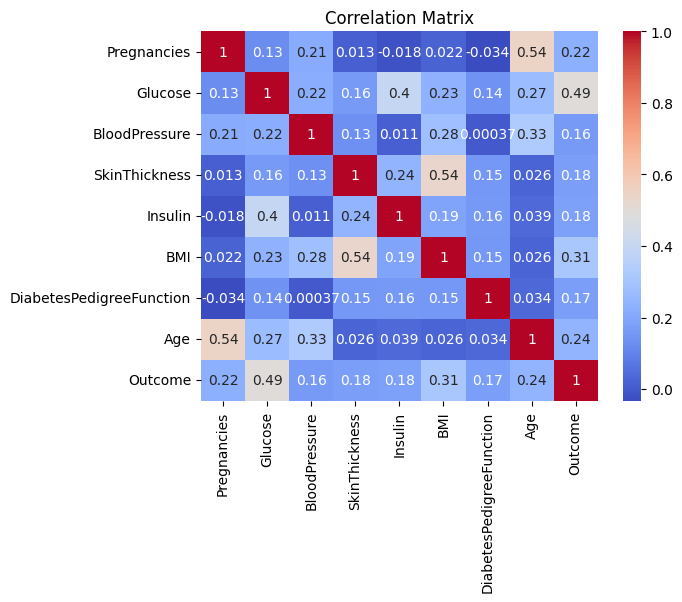

Важные признаки: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [10]:
# Тепловая карта корреляций
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Важные признаки (корреляция с Outcome > 0.1)
important_cols = corr['Outcome'][abs(corr['Outcome']) > 0.1].index.drop('Outcome')
print("Важные признаки:", important_cols.tolist())

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Разделение
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Модель 1: Логистическая регрессия
model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train, y_train)
print("Logistic Accuracy:", model1.score(X_test, y_test))

# Модель 2: Random Forest
model2 = RandomForestClassifier(n_estimators=100, random_state=42)
model2.fit(X_train, y_train)
print("RF Accuracy:", model2.score(X_test, y_test))

Logistic Accuracy: 0.7662337662337663
RF Accuracy: 0.7662337662337663


In [12]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Предсказания
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)

# Метрики
print("Logistic - Accuracy:", accuracy_score(y_test, y_pred1))
print("Logistic - F1:", f1_score(y_test, y_pred1))
print("Logistic - ROC-AUC:", roc_auc_score(y_test, model1.predict_proba(X_test)[:, 1]))

print("RF - Accuracy:", accuracy_score(y_test, y_pred2))
print("RF - F1:", f1_score(y_test, y_pred2))
print("RF - ROC-AUC:", roc_auc_score(y_test, model2.predict_proba(X_test)[:, 1]))

Logistic - Accuracy: 0.7662337662337663
Logistic - F1: 0.660377358490566
Logistic - ROC-AUC: 0.822038567493113
RF - Accuracy: 0.7662337662337663
RF - F1: 0.6896551724137931
RF - ROC-AUC: 0.8369146005509642


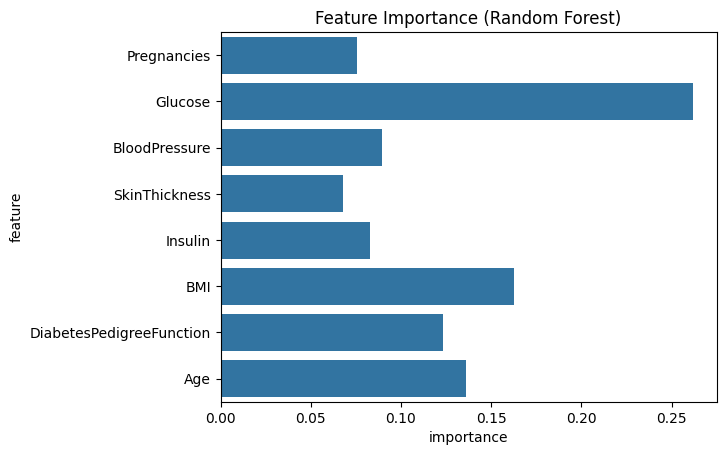

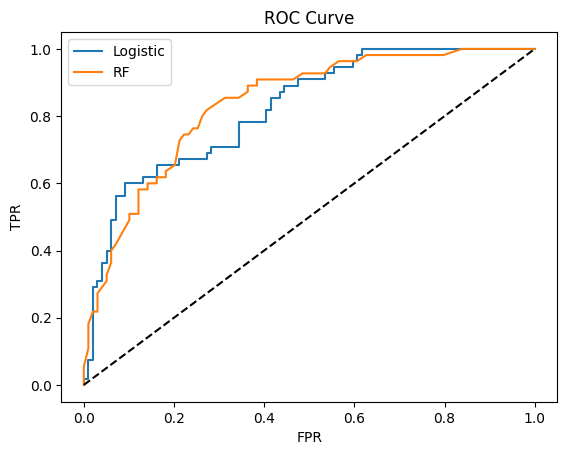

In [13]:
# Feature Importance
importances = pd.DataFrame({'feature': X.columns, 'importance': model2.feature_importances_})
sns.barplot(x='importance', y='feature', data=importances)
plt.title('Feature Importance (Random Forest)')
plt.show()

# ROC-кривая
from sklearn.metrics import roc_curve
fpr1, tpr1, _ = roc_curve(y_test, model1.predict_proba(X_test)[:, 1])
fpr2, tpr2, _ = roc_curve(y_test, model2.predict_proba(X_test)[:, 1])
plt.plot(fpr1, tpr1, label='Logistic')
plt.plot(fpr2, tpr2, label='RF')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()